# Домашнее задание
Построение модели логистической регрессии, настройка гиперпараметров на кросс-валидации, интерпретация коэффициентов.

**Цель**: В этом домашнем задании вы потренируетесь в настройке модели логистической регрессии, подборе коэффициента регуляризации и интерпретации результатов.
Снова про болезни, на этот раз про рак груди. Нужно научиться предсказывать, является ли клеточное образование злокачественным или нет.

1) Скачайте данные с Kaggle - https://www.kaggle.com/uciml/breast-cancer-wisconsin-data#data.csv

2) Как всегда - базовые статистики, визуализации (распределения, корреляции, pair-plots). В тех графиках, которые это позволяют, раскрасьте значения в зависимости от того, является опухоль злокачественной или нет.

3) Как вы помните, логистическая регрессия плохо относится к линейно-зависимым признакам, во время предобработки, уберите переменные, корреляция пирсона между которыми превышает 0.85. Разбейте данные на train-test, отложив 30% выборки для тестирования. Приведите все непрерывные переменные к одному масштабу при помощи стандартизации.

4) Постройте модель логистической регрессии "из коробки" без настройки параметров. Оцените метрики качества бинарной классификации (accuracy, precision, recall, f1_score), постройте ROC-кривую и посчитайте площадь под ней. Визуализируйте влияние коэффициентов на целевую переменную.

5) Теперь проведите настройку параметра регуляризации C на кросс-валидации (LogisticRegressionCV). Снова оцените результаты и постройте визуализацию влияния коэффициентов на целевую переменную. Сделайте интересные выводы :)

Бонусное задание - постройте также модель KNN с настройкой числа соседей на CV. У какой модели качество оказалось выше?

In [218]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings("ignore")

In [1]:
df = pd.read_csv("datasets/06/data.csv").drop("Unnamed: 32", axis=1)

NameError: name 'pd' is not defined

# 1. Обзор

In [9]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [10]:
df.tail()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400
568,92751,B,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,...,9.456,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039


In [11]:
df.shape

(569, 32)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
id                         569 non-null int64
diagnosis                  569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non

In [78]:
df.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


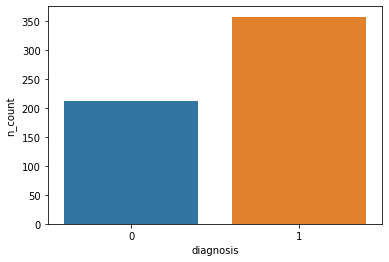

In [229]:
sns.barplot(data=df.groupby("diagnosis").size().to_frame("n_count").reset_index(),\
            x="diagnosis", y="n_count", orient="v")
plt.show()

# 2. EDA 

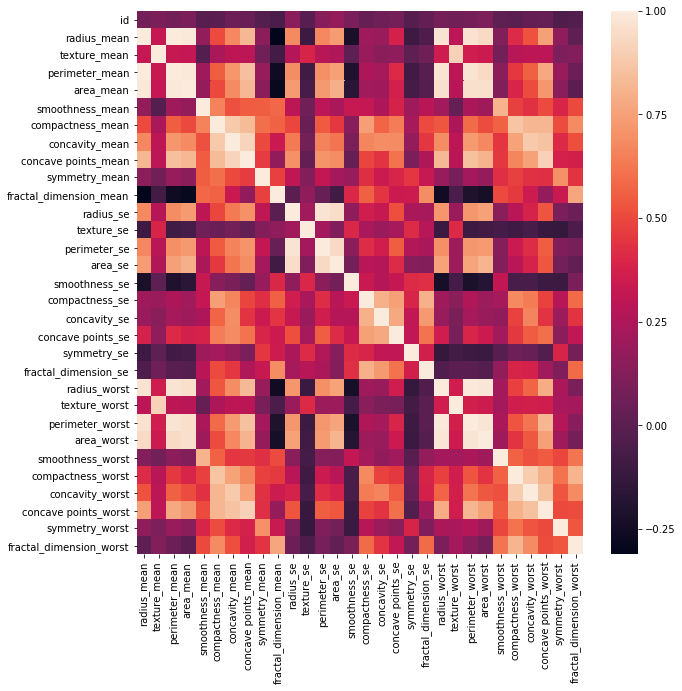

In [40]:
plt.figure(figsize=(10,10))
sns.heatmap(data=df.corr().drop("id", axis=1))

In [230]:
# Находим признаки, сильно коррелирующие между собой. В данном случае коэффициент корреляции по Пирсану более 85%

THRESHOLD = 0.85

c = df.corr()
corrField = []
Colls = []
for i in c:
    for j in c.index[abs(c[i])>THRESHOLD]:
        if i!=j and j not in corrField and i not in corrField:
            print(i, j , c[i][c.index==j].values[0])
            Colls.append(i)
            Colls.append(j)

radius_mean perimeter_mean 0.9978552814938113
radius_mean area_mean 0.9873571700566119
radius_mean radius_worst 0.9695389726112053
radius_mean perimeter_worst 0.9651365139559878
radius_mean area_worst 0.9410824595860459
texture_mean texture_worst 0.9120445888404215
perimeter_mean radius_mean 0.9978552814938113
perimeter_mean area_mean 0.9865068039913906
perimeter_mean concave points_mean 0.8509770412528199
perimeter_mean radius_worst 0.9694763634663142
perimeter_mean perimeter_worst 0.9703868870426388
perimeter_mean area_worst 0.9415498080023057
area_mean radius_mean 0.9873571700566119
area_mean perimeter_mean 0.9865068039913906
area_mean radius_worst 0.9627460860470841
area_mean perimeter_worst 0.959119574355266
area_mean area_worst 0.9592133256499006
compactness_mean concavity_mean 0.8831206701772499
compactness_mean compactness_worst 0.8658090398022638
concavity_mean compactness_mean 0.8831206701772499
concavity_mean concave points_mean 0.9213910263788594
concavity_mean concavity_wo

In [260]:
# Создаем список сильно коррелирующих признаков. Также добавляем туда целевую переменную diagnosis для визуализации

CollsUnique = list(set(Colls))
# CollsUnique.extend(['diagnosis'])

In [259]:
CollsUnique[:9].extend('diagnosis')

In [265]:
c1 = CollsUnique[:9]+['diagnosis']
c2 = CollsUnique[9:]+['diagnosis']

<Figure size 1440x1440 with 0 Axes>

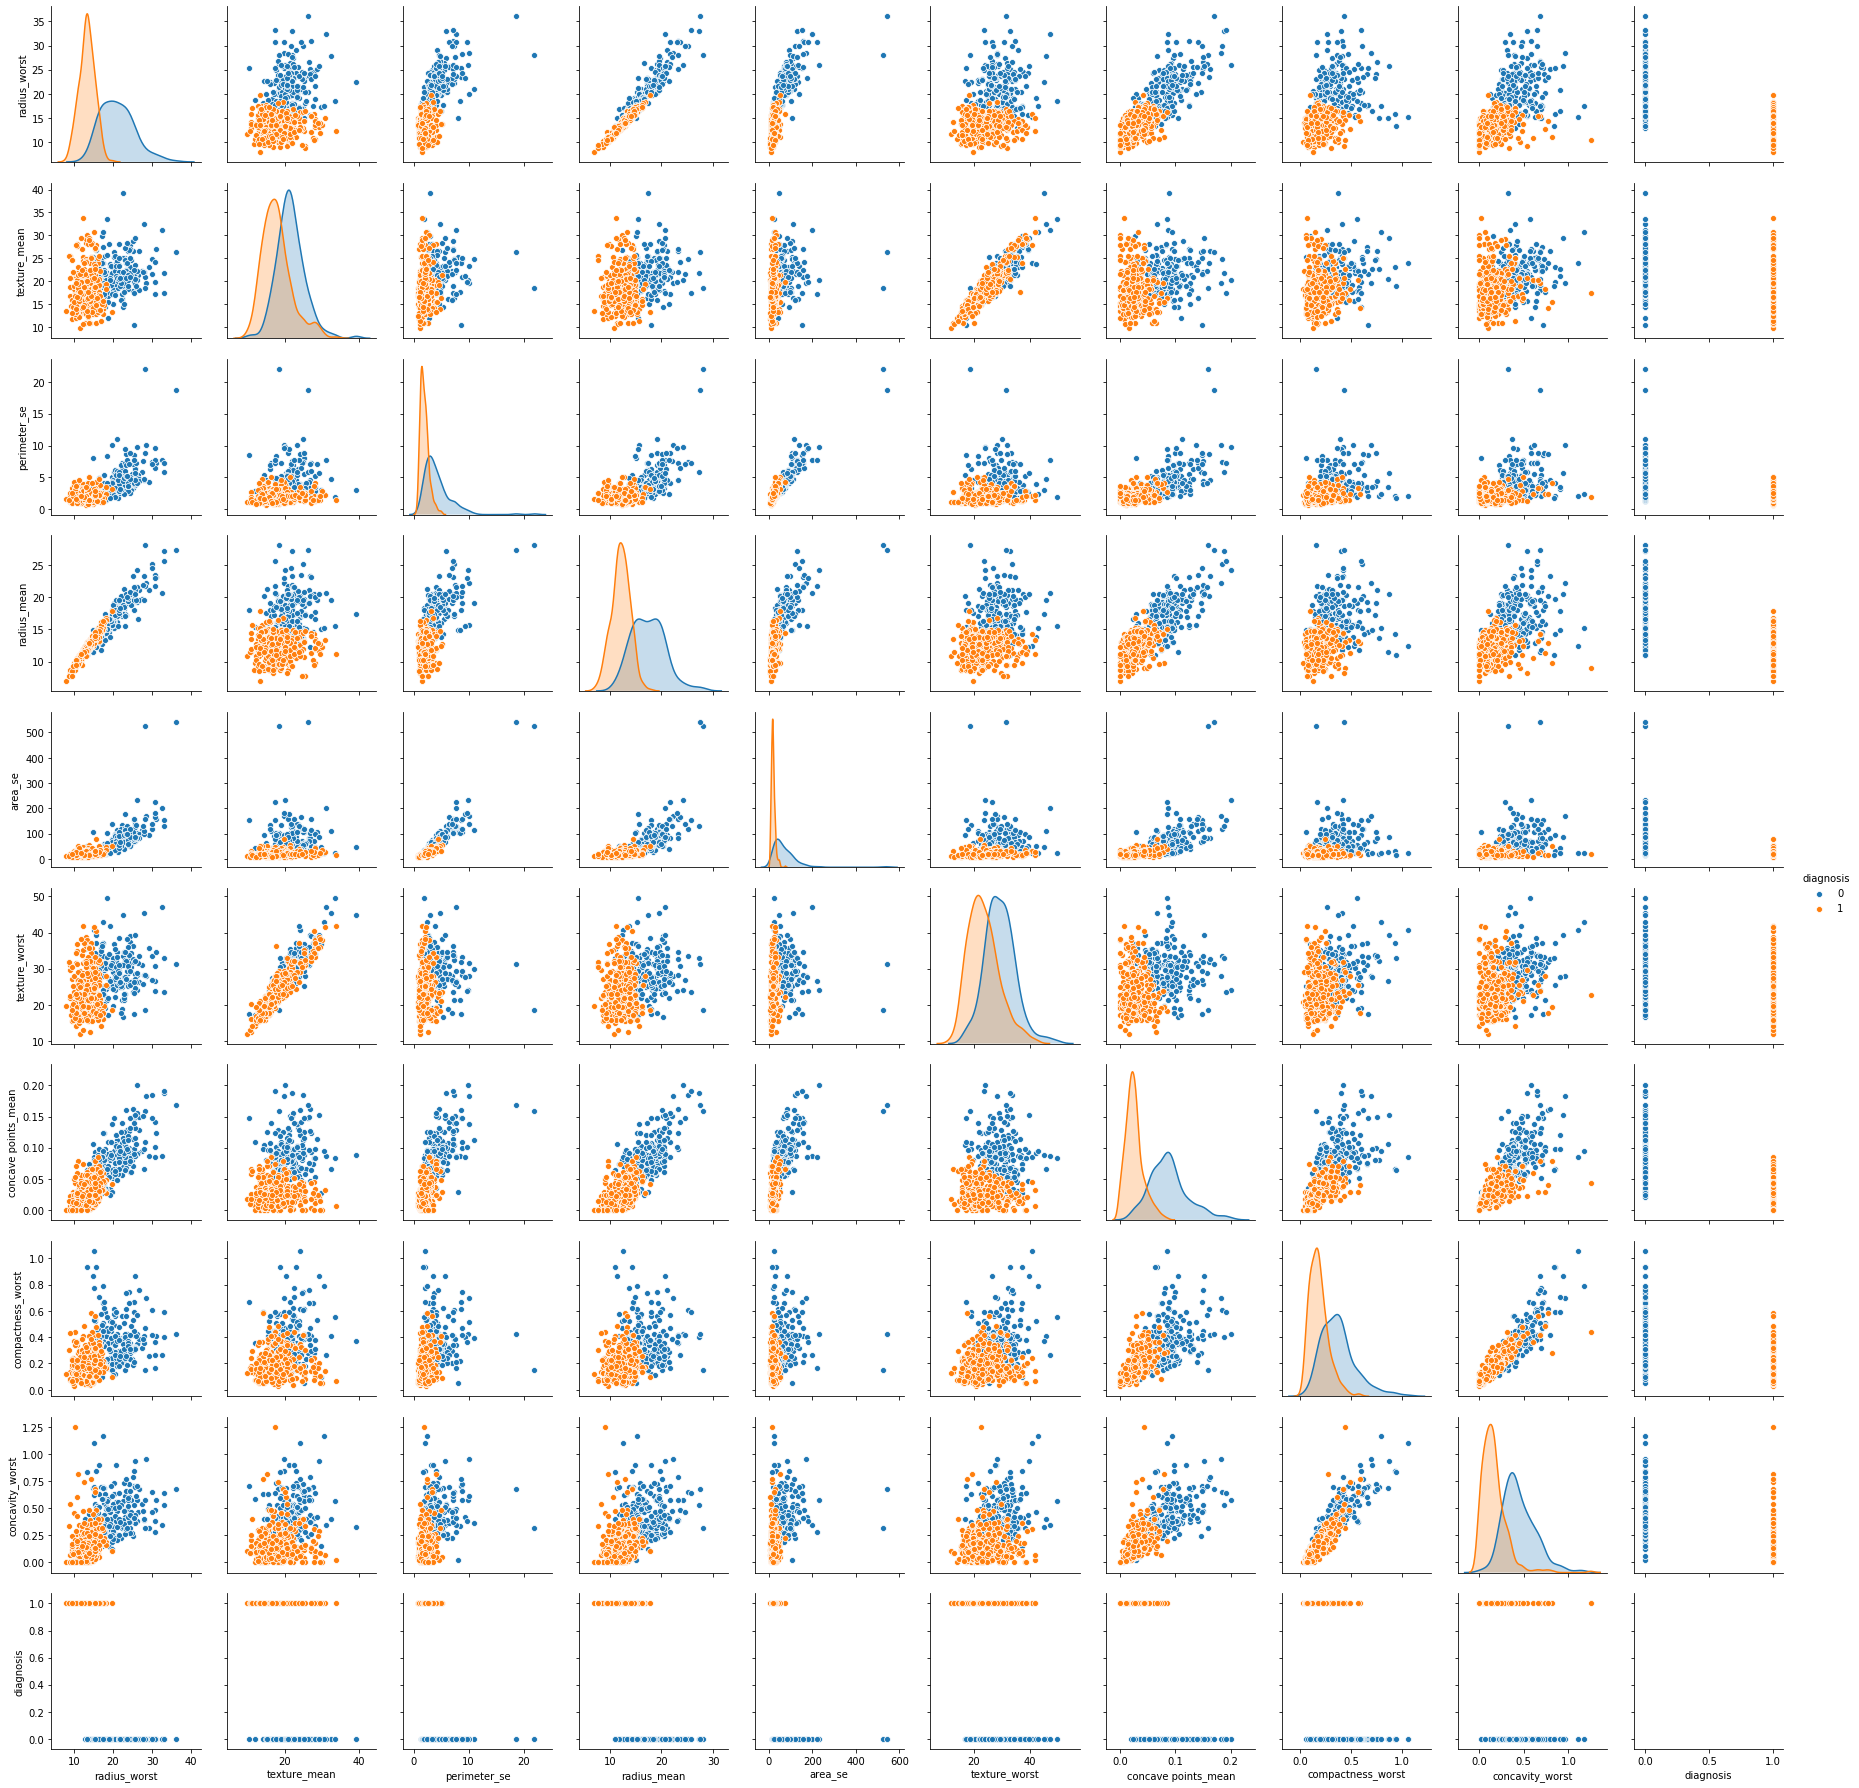

In [266]:
# Строим парный график для наблюдения зависимостей между переменными 
plt.figure(figsize=(20,20))
sns.pairplot(data=df[c1], hue="diagnosis")
plt.show()

<Figure size 1440x1440 with 0 Axes>

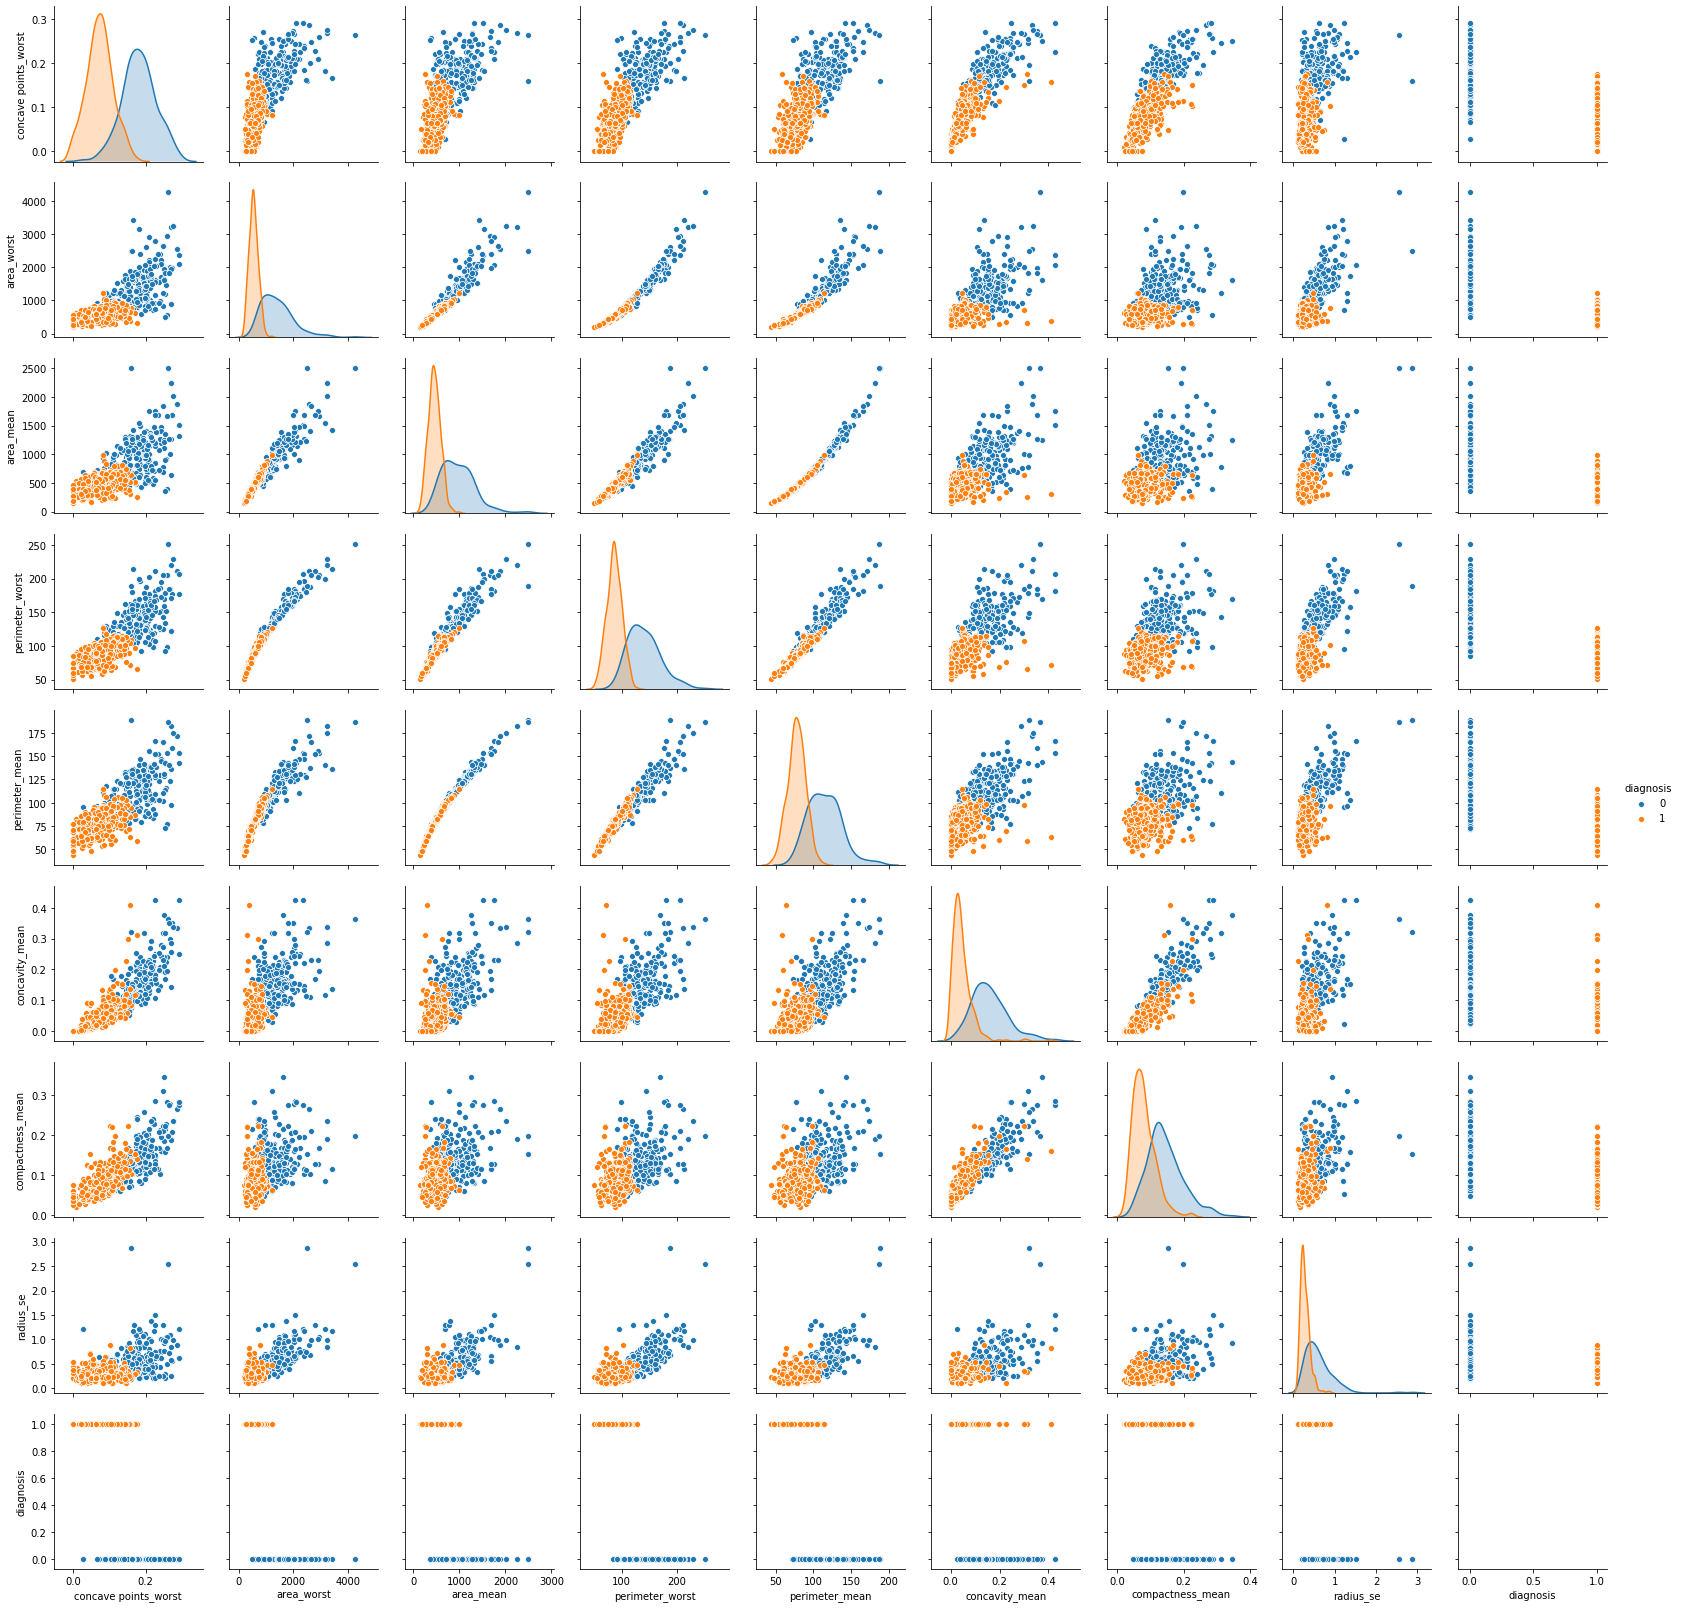

In [267]:
plt.figure(figsize=(20,20))
sns.pairplot(data=df[c2], hue="diagnosis")
plt.show()

# Моделирование

In [121]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 

In [141]:
def quality_report(prediction, actual):
    print("Accuracy: {:.3f}\nPrecision: {:.3f}\nRecall: {:.3f}\nf1_score: {:.3f}".format(
        accuracy_score(prediction, actual),
        precision_score(prediction, actual),
        recall_score(prediction, actual),
        f1_score(prediction, actual)
    ))

In [147]:
df["diagnosis"] = df["diagnosis"].apply(lambda x: 1 if x=="B" else 0)

In [205]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("diagnosis", axis=1), \
                                                    df.diagnosis, \
                                                   test_size=0.3)

In [206]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((398, 31), (171, 31), (398,), (171,))

In [207]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [208]:
regressor = LogisticRegression(solver="lbfgs")

In [209]:
regressor.fit(X_train_scaled, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [210]:
quality_report(regressor.predict(X_train_scaled), y_train)

Accuracy: 0.987
Precision: 0.996
Recall: 0.984
f1_score: 0.990


In [211]:
quality_report(regressor.predict(X_test_scaled), y_test)

Accuracy: 0.994
Precision: 1.000
Recall: 0.991
f1_score: 0.996


In [212]:
feature_weights = pd.DataFrame({"features":df.drop("diagnosis", axis=1).columns, \
                                "weights":regressor.coef_[0]})\
                                .sort_values("weights", ascending=False)

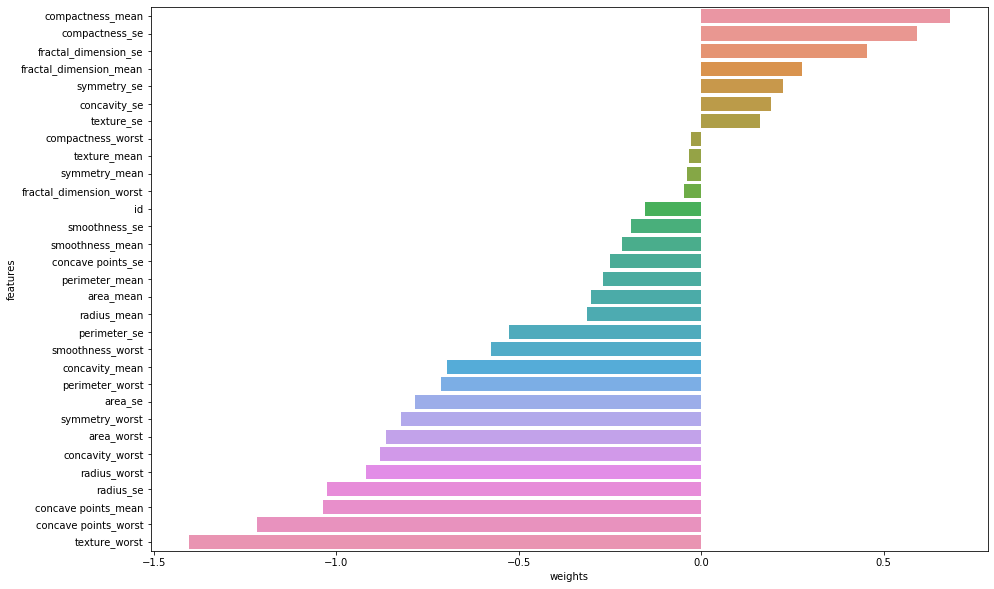

In [213]:
plt.figure(figsize=(15,10))
sns.barplot(x="weights", y="features", data=feature_weights)

In [214]:
from sklearn.metrics import roc_auc_score, roc_curve

def plot_roc_curve(prob_prediction, actual):
    fpr, tpr, thresholds = roc_curve(y_test, prob_prediction)
    auc_score = roc_auc_score(y_test, prob_prediction)
    
    plt.plot(fpr, tpr, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC: {:.3f}'.format(auc_score))
    plt.show()

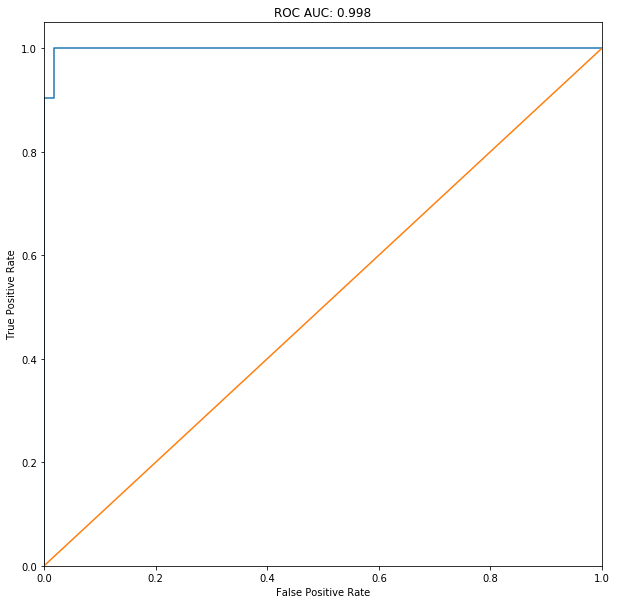

In [215]:
plt.figure(figsize=(10,10))
plot_roc_curve(regressor.predict_proba(X_test_scaled)[:,1], y_test)

CV

In [220]:
regressor_cv = LogisticRegressionCV(Cs=50)
regressor_cv.fit(X_train_scaled, y_train)
print("Train quality:")
quality_report(regressor_cv.predict(X_train_scaled), y_train)
print("\nTest quality:")
quality_report(regressor_cv.predict(X_test_scaled), y_test)

Train quality:
Accuracy: 0.982
Precision: 0.992
Recall: 0.980
f1_score: 0.986

Test quality:
Accuracy: 0.982
Precision: 1.000
Recall: 0.975
f1_score: 0.987


In [222]:
feature_weights_cv = pd.DataFrame({"features":df.drop("diagnosis", axis=1).columns, \
                                "weights":regressor_cv.coef_[0]})\
                                .sort_values("weights", ascending=False)

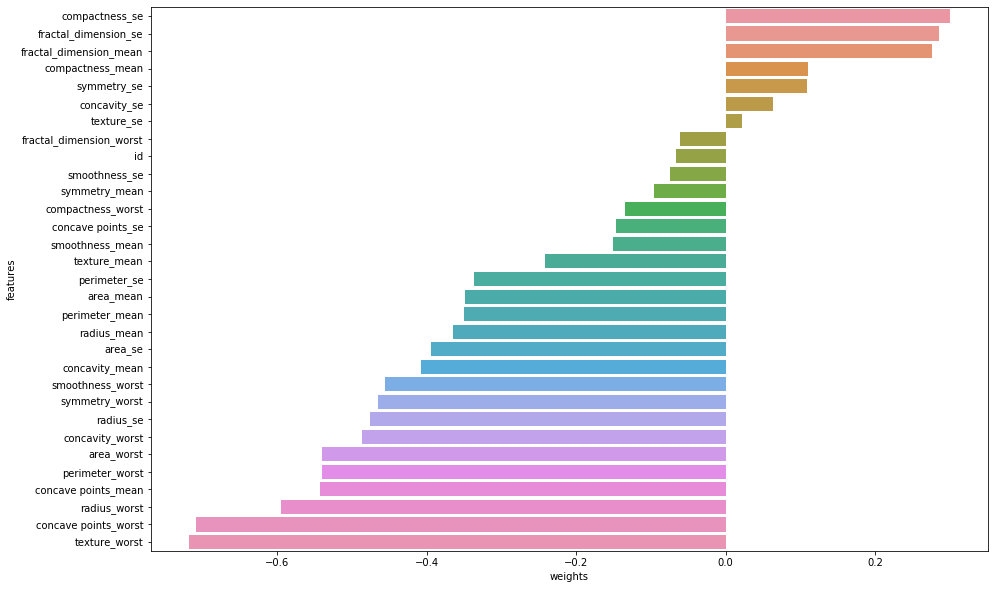

In [224]:
plt.figure(figsize=(15,10))
sns.barplot(x="weights", y="features", data=feature_weights_cv)